In [3]:
#using Pkg
#Pkg.add("SpecialFunctions")
using SpecialFunctions
using Statistics
using Plots

function calculate_g1()
    # rand motion, Eq. 16
    return 2 * rand() - 1  # Eq. 16
end

function calculate_g2(iteration::Integer, max_iterations::Integer)
    # Flight slope of aquila, Eq. 17
    return 2 * (1 - iteration / max_iterations)
end

function calculate_spiral_search(
    num_dimensions::Integer,
    r1::Float64,
    miu::Float64,
    w::Float64
)
    # Spiral search Eq.(9, 10)
    dim_list = [i for i in range(1, num_dimensions)]
    r = r1 .+ miu .* dim_list
    phi0 = 3 * pi / 2
    phi = -w .* dim_list .+ phi0
    x = r .* sin.(phi)  
    y = r .* cos.(phi)  

    return x, y
end

function calculate_quality_function(
    iteration::Integer, 
    max_iterations::Integer
)
    # Quality function, Eq.(15)
    iteration ^ ((2 * rand() - 1) / (1 - max_iterations) ^ 2)  
end

function get_levy_flight_step(
    beta::Float64
)
    # u and v are two rand variables which follow normal distribution
    # sigma_u : standard deviation of u
    sigma = gamma(1.0 + beta) * sin(pi * beta / 2) / (gamma((1 + beta) / 2.) * beta * (2. ^ ((beta - 1) / 2)))

    # levy step, Eq. 6
    step = rand() * sigma / (abs(rand()) ^ (1 / beta))
    
    return step
end

function generate_initial_pop(lower, upper, dimensions, pop_size)
    positions = rand(pop_size, dimensions) .* (upper - lower) .+ lower
    return positions
end

function get_best_position(f,
    population::Array{Float64, 2},
    fitness::Array{Float64, 1}
)
    min_index = argmin(fitness)
    return population[min_index, :], fitness[min_index]
end

function expanded_exploration(
    best_position::Array{Float64, 1},
    iteration::Integer,
    max_iterations::Integer,
    x_mean::Array{Float64, 1}
)
    return best_position * (1 - iteration / max_iterations) .+ rand() * (x_mean .- best_position)
end


function rand_individual(
    population::Array{Float64, 2},
    skip_index::Integer
)
    # Get the number of individuals in the population
    num_individuals = size(population, 1)
    
    # Filter out the skip_index
    filtered_indices = filter(x -> x != skip_index, 1:num_individuals)

    # Select a random index from the filtered array
    index = rand(filtered_indices)

    return population[index, :]
end


function narrowed_exploration(
    current_index::Integer,
    population::Array{Float64, 2},
    best_position::Array{Float64, 1},
    beta::Float64,
    r1::Float64,
    miu::Float64,
    w::Float64
)
    levy_step = get_levy_flight_step(beta)
    
    # Define spiral search
    x, y = calculate_spiral_search(size(population, 2), r1, miu, w)

    # Use Eq. 5 to compute narrowed exploration
    return best_position * levy_step .+ rand_individual(population, current_index) .+ rand() * (y - x)  
end

function expanded_exploitation(
    alpha::Float64,
    delta::Float64,
    best_position::Array{Float64, 1},
    x_mean::Array{Float64, 1},
    upper::Array{Float64, 1},
    lower::Array{Float64, 1}
)
    # Compute expanded exploitation from Eq. 13
    return alpha .* (best_position .- x_mean) - rand() .* (rand() .* (upper .- lower) .+ lower) .* delta
end

function narrowed_exploitation(
    iteration::Integer,
    max_iterations::Integer,
    individual::Array{Float64, 1},
    best_position::Array{Float64, 1},
    beta::Float64
)
    levy_step = get_levy_flight_step(beta)

    # Quality function
    qf = calculate_quality_function(iteration, max_iterations)

    # Flight slope and rand movement parameters
    g1 = calculate_g1()
    g2 = calculate_g2(iteration, max_iterations)

    # Eq. 14
    return qf .* best_position .- (g2 .* individual .* rand()) .- g2 .* levy_step .+ rand() .* g1  
end

function evolve!(
    f,
    positions,
    fitness,
    upper::Array{Float64, 1},
    lower::Array{Float64, 1},
    max_iterations:: Integer,
    alpha::Float64 = 0.1,
    delta::Float64 = 0.1,
    r1::Float64 = 10.0,
    miu::Float64 = 0.00565,
    w::Float64 = 0.005,
    beta::Float64 = 1.5
)
    best_fitness_array = []
    
    # Calculate global population values
    best_position, best_fitness = get_best_position(f, positions, fitness)

    for iteration in 1:max_iterations
        push!(best_fitness_array, best_fitness)
        # Generate a new population. Assume this happens in place?
        for idx in 1:size(positions, 1)
            # Update mean each time as individuals update positions
            x_mean = vec(mean(positions, dims=1))
    
            # Find a new position for this individual
            if iteration <= (2 / 3) * max_iterations
                if rand() < 0.5
                    pos_new = expanded_exploration(best_position, iteration, max_iterations, x_mean)
                else
                    pos_new = narrowed_exploration(idx, positions, best_position, beta, r1, miu, w)
                end
            else
                if rand() < 0.5
                    pos_new = expanded_exploitation(alpha, delta, best_position, x_mean, upper, lower)
                else
                    pos_new = narrowed_exploitation(iteration, max_iterations, positions[idx, :], best_position, beta)
                end
            end
            
            # Evaluate the position
            fitness_new = f(pos_new)
            
            # If better, replace
            if fitness_new < fitness[idx]
                positions[idx, :] = pos_new
                fitness[idx] = fitness_new
                
                if fitness_new < best_fitness
                    best_position = pos_new
                    best_fitness = fitness_new                
                end
            end
        end
    end
    return best_fitness_array
end

function AO_report(f, lower, upper, dimensions, pop_size, max_iterations, num_trials)
    all_best_costs = zeros(num_trials, max_iterations) # Adjusted to use max_iterations
    for i in 1:num_trials
        positions = generate_initial_pop(lower, upper, dimensions, pop_size)
        fitness = [f(positions[i, :]) for i in 1:pop_size]
        best_costs = evolve!(f,
                             positions,
                             fitness,
                             fill(upper, dimensions),
                             fill(lower, dimensions),
                             max_iterations
                             )
        all_best_costs[i, :] = best_costs
    end
    avg_best_costs = mean(all_best_costs, dims=1)

    # Plotting might need adjustments based on actual best_costs size
    p = plot(1:max_iterations, avg_best_costs[:], label="Average Best Cost", xlabel="Generation", ylabel="Cost")
    display(p)
    
    # Extract statistics for the final iteration
    final_costs = all_best_costs[:, end] # Extract the last column
    
    # Print the worst, best, average costs, and standard deviation at the final iteration
    println("Worst cost at final iteration: $(maximum(final_costs))")
    println("Best cost at final iteration: $(minimum(final_costs))")
    println("Average cost at final iteration: $(mean(final_costs))")
    println("STD of best cost at final iteration: $(std(final_costs))")
end

AO_report (generic function with 1 method)

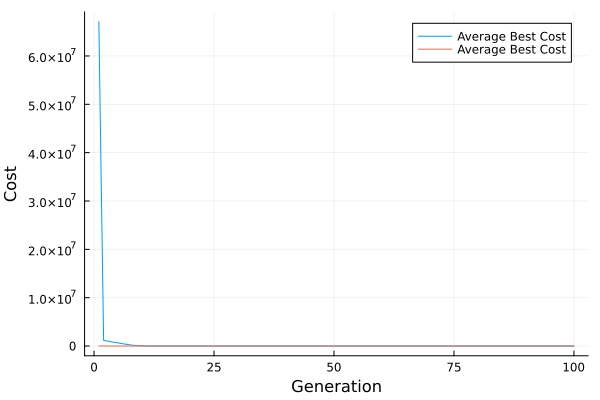

F1
Worst cost at final iteration: 2.788278001315284e-15
Best cost at final iteration: 7.514061073416992e-18
Average cost at final iteration: 4.773132397170638e-16
STD of best cost at final iteration: 8.352502158436337e-16
F2
Worst cost at final iteration: 1.6778186783931198e-7
Best cost at final iteration: 2.1090865391714522e-8
Average cost at final iteration: 5.573958827570035e-8
STD of best cost at final iteration: 4.351382293224378e-8
F3
Worst cost at final iteration: 7.013766808734632e-14
Best cost at final iteration: 9.893524610028572e-18
Average cost at final iteration: 1.3870905033922136e-14
STD of best cost at final iteration: 2.791356749973149e-14
F4
Worst cost at final iteration: 1.1670629791723168e-7
Best cost at final iteration: 1.1396448774734918e-9
Average cost at final iteration: 2.5142259393671987e-8
STD of best cost at final iteration: 4.2349684866392796e-8
F5
Worst cost at final iteration: 0.11876268604635848
Best cost at final iteration: 0.0002609189523848858
Average

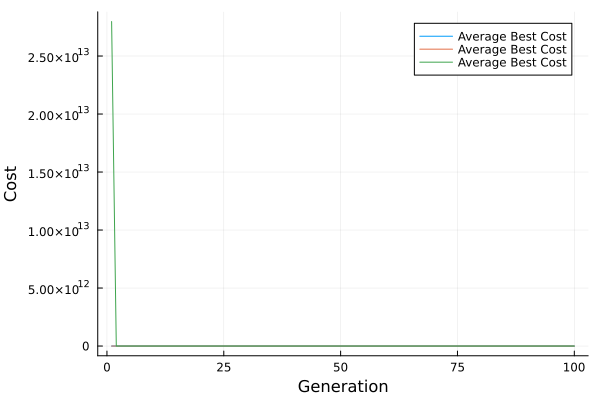

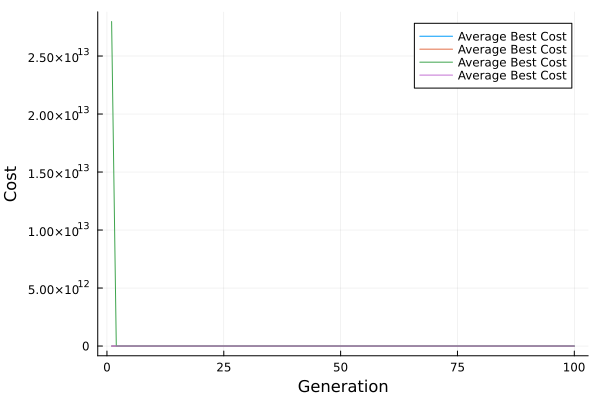

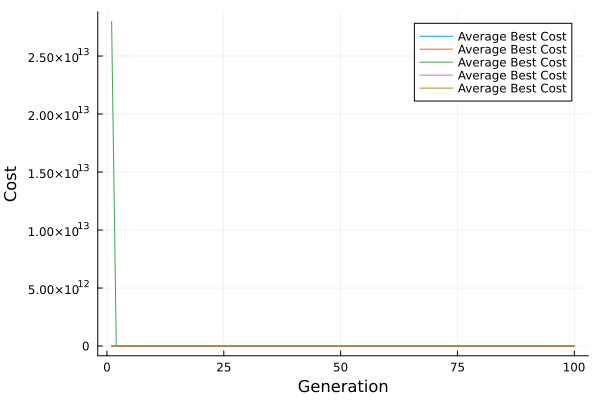

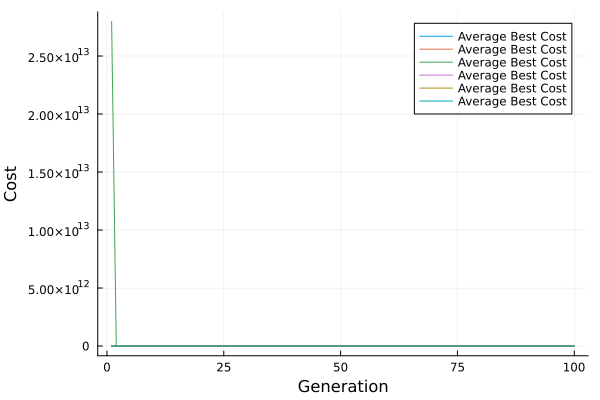

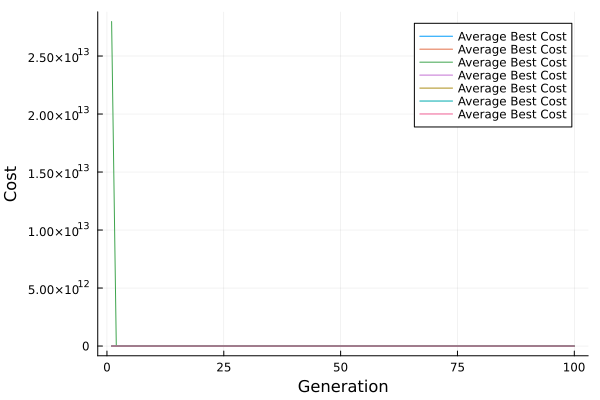

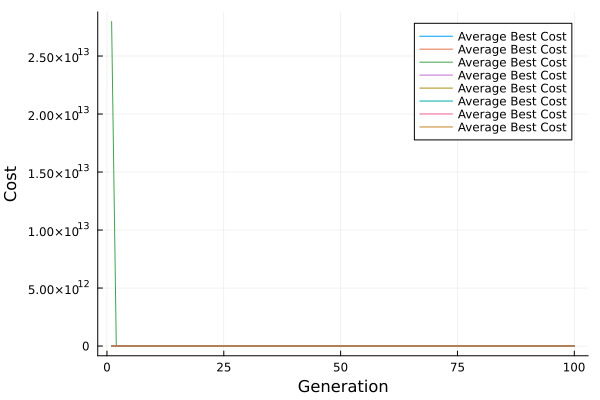

In [4]:
# Function F1
function F1(x::Vector)
    return sum(x .^ 2)
end

# Function F2
function F2(x::Vector)
    return sum(abs.(x)) + prod(abs.(x))
end

# Function F3
function F3(x::Vector)
    return sum([sum(x[1:i])^2 for i in 1:length(x)])
end

# Function F4
function F4(x::Vector)
    return maximum(abs.(x))
end

# Function F5
function F5(x::Vector)
    return sum(100 .* (x[1:end-1] .^ 2 .- x[2:end]) .^ 2 .+ (1 .- x[1:end-1]) .^ 2)
end

# Function F6
function F6(x::Vector)
    return sum((x .+ 0.5).^2)
end

# Function F7
function F7(x::Vector)
    return sum(x.^4) + rand()
end

# Define optimization parameters
lower = -100.0
upper = 100.0
dimensions = 10
pop_size = 20
max_iterations = 100
num_trials = 10

for f in [F1, F2, F3, F4, F5, F6, F7]
    println(f)
    AO_report(f, lower, upper, dimensions, pop_size, max_iterations, num_trials)
end